In [14]:
import geopandas
import matplotlib.pyplot as mp
import cartopy
import numpy
import xarray
import cmocean
#import rasterio
import shapely
import itertools
import scipy.ndimage
import datetime
import glob

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial']

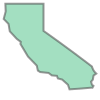

In [3]:
states_gdf = geopandas.read_file('/glade/u/home/baird/_shapefiles/_natural_earth_data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')
#coastlines_gs = geopandas.GeoSeries.from_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/ne_110m_coastline/ne_110m_coastline.shp')
ca_gdf = states_gdf[states_gdf['iso_3166_2']=='US-CA']
#ca_gdf.crs
#ca_gdf.crs['init'][-4:]
ca_gdf['geometry'].values[0]

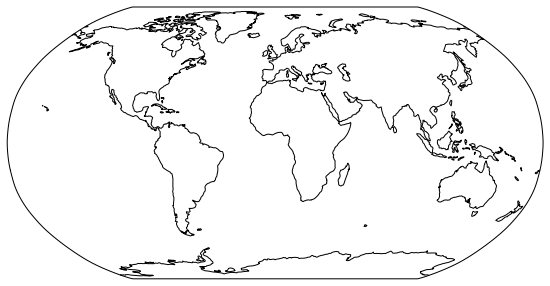

In [4]:
fig = mp.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=cartopy.crs.Robinson())
ax.coastlines()

In [5]:
#lon_lo, lon_hi, lat_lo, lat_hi = 235.25, 246.25, 32., 42.5
#lon_lo, lon_hi, lat_lo, lat_hi = 200,280,10,70
lon_lo, lon_hi, lat_lo, lat_hi = 232,255, 30., 50

In [6]:
ncfile = xarray.open_dataset('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h0.PSL.040001-049912.nc')
psl_data = ncfile['PSL'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
psl_lat = ncfile['lat'].sel(lat=slice(lat_lo,lat_hi)).values
psl_lon = ncfile['lon'].sel(lon=slice(lon_lo,lon_hi)).values

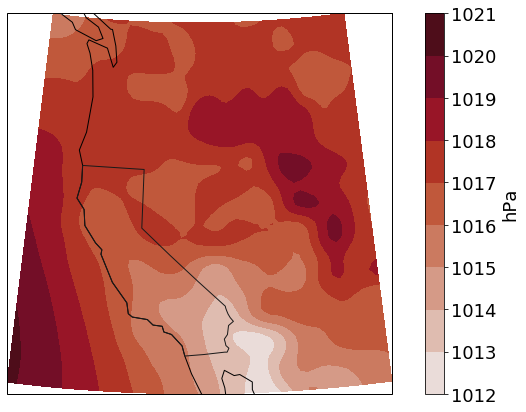

In [13]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
#ax.set_global()#extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_data.mean(axis=0)/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

psl_vals = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                      cmap=cmocean.cm.amp,transform=lens_proj)

# psl_vals = ax.contourf(psl_lon,psl_lat,psl_data.mean(axis=0)/100.,\
#                       cmap=cmocean.cm.amp,transform=lens_proj)

cbar = mp.colorbar(psl_vals)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

take ONDJFM mean

In [15]:
hist_files = sorted(glob.glob('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/b.e11.B20TRC5CNBDRD.f09_g16.???.cam.h0.PSL.*'))
rcp_files = sorted(glob.glob('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/b.e11.BRCP85C5CNBDRD.f09_g16.???.cam.h0.PSL.*210012.nc'))

import history data

In [16]:
psl_hist_data_list = []

for i,f in enumerate(hist_files):
    #print(i+1)
    ncfile_tmp = xarray.open_dataset(f)
    if i==0:
        psl_data_tmp = ncfile_tmp['PSL'].sel(lat=slice(lat_lo,lat_hi),\
                                         lon=slice(lon_lo,lon_hi))
        psl_data_tmp = psl_data_tmp.isel(time=slice((1920-1850)*12,None)).values
    else:
        psl_data_tmp = ncfile_tmp['PSL'].sel(lat=slice(lat_lo,lat_hi),\
                                         lon=slice(lon_lo,lon_hi)).values
    psl_hist_data_list.append(psl_data_tmp)
    ncfile_tmp.close()

In [40]:
psl_time_hist = xarray.open_dataset(hist_files[1])['time'].values - datetime.timedelta(days=15)
ondjfm_indices_hist = [t.month in [10,11,12,1,2,3] and t.year in range(1981,2001) for t in psl_time_hist]
month_indices_hist = [t.month in [11] and t.year in range(1981,2001) for t in psl_time_hist]

import rcp data

In [18]:
psl_rcp_data_list = []

for i,f in enumerate(rcp_files[:40]):
    #print(i+1)
    ncfile_tmp = xarray.open_dataset(f)

    psl_data_tmp = ncfile_tmp['PSL'].sel(lat=slice(lat_lo,lat_hi),\
                                         lon=slice(lon_lo,lon_hi),\
                                         time=slice('2081-01-31','2101-01-31')).values
#     else:
#         psl_data_tmp = ncfile_tmp['PSL'].sel(lat=slice(lat_lo,lat_hi),\
#                                              lon=slice(lon_lo,lon_hi),\
#                                              time=slice('2081-01-01','2100-12-31'))
    psl_rcp_data_list.append(psl_data_tmp)
    ncfile_tmp.close()

In [39]:
psl_time_rcp = xarray.open_dataset(rcp_files[0]).sel(time=slice('2081-01-31','2101-01-31'))['time'].values - datetime.timedelta(days=15)
ondjfm_indices_rcp = [t.month in [10,11,12,1,2,3] and t.year in range(2081,2101) for t in psl_time_rcp]
month_indices_rcp = [t.month in [11] and t.year in range(2081,2101) for t in psl_time_rcp]

take means of hist and rcp data

In [44]:
psl_hist_data_list_ondjfm = [l[ondjfm_indices_hist,:,:] for l in psl_hist_data_list]
psl_hist_ondjfm_mean = numpy.mean(numpy.array(psl_hist_data_list_ondjfm), axis=(0,1))

psl_hist_data_list_month = [l[month_indices_hist,:,:] for l in psl_hist_data_list]
psl_hist_month_mean = numpy.mean(numpy.array(psl_hist_data_list_month), axis=(0,1))

In [46]:
psl_rcp_data_list_ondjfm = [l[ondjfm_indices_rcp,:,:] for l in psl_rcp_data_list]
psl_rcp_ondjfm_mean = numpy.mean(numpy.array(psl_rcp_data_list_ondjfm), axis=(0,1))

psl_rcp_data_list_month = [l[month_indices_rcp,:,:] for l in psl_rcp_data_list]
psl_rcp_month_mean = numpy.mean(numpy.array(psl_rcp_data_list_month), axis=(0,1))

In [47]:
psl_ondjfm_diffs = psl_rcp_ondjfm_mean - psl_hist_ondjfm_mean
psl_month_diffs = psl_rcp_month_mean - psl_hist_month_mean

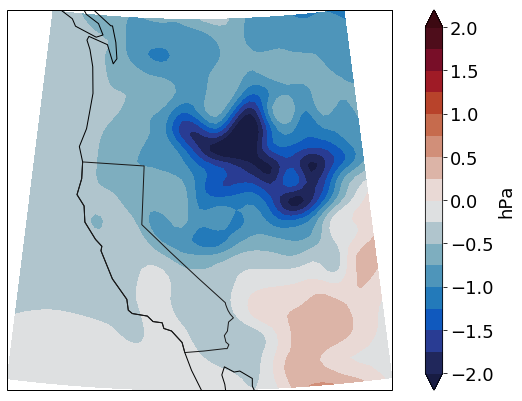

In [23]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
#ax.set_global()#extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_ondjfm_diffs/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(-2,2.1,0.25)
temps = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.balance,transform=lens_proj,\
                    extend='both', levels=clevels)

cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

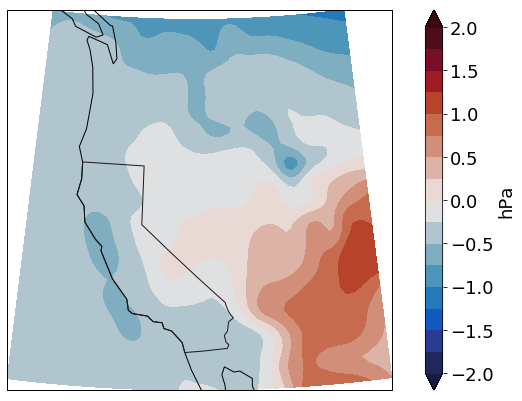

In [48]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
#ax.set_global()#extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_month_diffs/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(-2,2.1,0.25)
temps = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.balance,transform=lens_proj,\
                    extend='both', levels=clevels)

cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

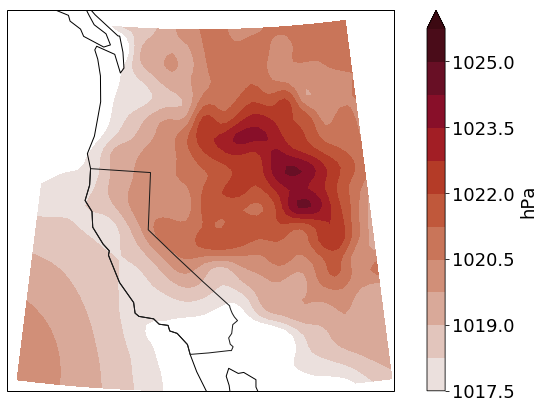

In [38]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_hist_ondjfm_mean/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(1017.5,1026,0.75)
psl_map = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.amp,transform=lens_proj,\
                    extend='max', levels=clevels)
# psl_contours = ax.contour(xi_smooth,yi_smooth,field_smooth,\
#                     colors=[cmocean.cm.amp(0.9)],transform=lens_proj,\
#                     extend='max', levels=[1022])

cbar = mp.colorbar(psl_map)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)

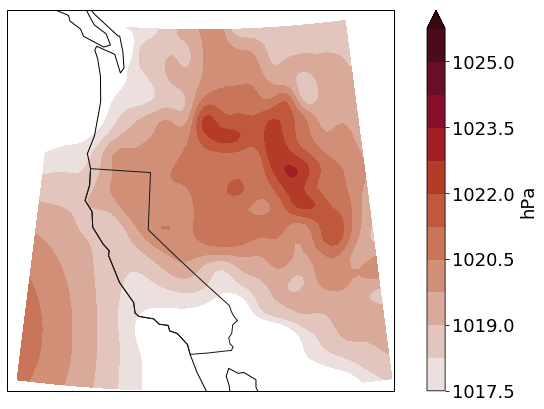

In [49]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_hist_month_mean/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(1017.5,1026,0.75)
psl_map = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.amp,transform=lens_proj,\
                    extend='max', levels=clevels)
# psl_contours = ax.contour(xi_smooth,yi_smooth,field_smooth,\
#                     colors=[cmocean.cm.amp(0.9)],transform=lens_proj,\
#                     extend='max', levels=[1022])

cbar = mp.colorbar(psl_map)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)

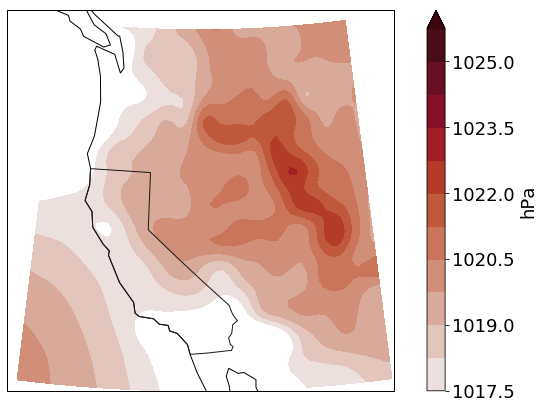

In [37]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_rcp_ondjfm_mean/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(1017.5,1026,0.75)
psl_map = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.amp,transform=lens_proj,\
                    extend='max', levels=clevels) 
# psl_contours = ax.contour(xi_smooth,yi_smooth,field_smooth,\
#                     colors=[cmocean.cm.amp(0.9),cmocean.cm.amp(0.7)],transform=lens_proj,\
#                     extend='max', levels=[1020,1021.25])

cbar = mp.colorbar(psl_map)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)

In [ ]:
fig = mp.figure(figsize=(12,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

#map_proj = cartopy.crs.PlateCarree()

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])
ax.coastlines()
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

field = psl_rcp_ondjfm_mean/100.
xi_smooth = scipy.ndimage.zoom(psl_lon,3)
yi_smooth = scipy.ndimage.zoom(psl_lat,3)
field_smooth = scipy.ndimage.zoom(field,3)

clevels = numpy.arange(1017.5,1026,0.75)
psl_map = ax.contourf(xi_smooth,yi_smooth,field_smooth,\
                    cmap=cmocean.cm.amp,transform=lens_proj,\
                    extend='max', levels=clevels) 
# psl_contours = ax.contour(xi_smooth,yi_smooth,field_smooth,\
#                     colors=[cmocean.cm.amp(0.9),cmocean.cm.amp(0.7)],transform=lens_proj,\
#                     extend='max', levels=[1020,1021.25])

cbar = mp.colorbar(psl_map)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('hPa', fontsize=18)